# Выбор локации для скважины

Перед нами предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 
Наша задача - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

## Загрузка и подготовка данных

Загрузим данные из файлов

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import warnings
# настройки
warnings.filterwarnings("ignore")

In [2]:
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    print("Не удалось прочитать файл")

In [3]:
#Создадим фкнкцию для получения информации от каждого датасета
def dataset_info(dataset):
    display('Первые пять строк датасета')
    display(dataset.head())
    display('Информация о датасете')
    display(dataset.info())
    display('Описание датасета')
    display(dataset.describe(include='all'))
    display('Гистограммы')
    display(dataset.hist(bins=15,figsize=(10,10)));
    

Цель нашего проекта посчитать прибыль и риски для каждого региона и выбрать наиболее рентабельный. 
Для этого:
1. Изучим данные о регионах;
2. Построим модель линейной регрессии для определения кол-ва бареллей в регионах. Является обучение с учителем. Изучим качество модели.
3. Расчитаем прибыль и риски убытка.

**Инормация о датасета**:
- /datasets/geo_data_0.csv. - Регион 1
- /datasets/geo_data_1.csv. - Регион 2
- /datasets/geo_data_2.csv. - Регион 3
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### Информация о первом регионе

'Первые пять строк датасета'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Описание датасета'

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,QcMuo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


'Гистограммы'

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

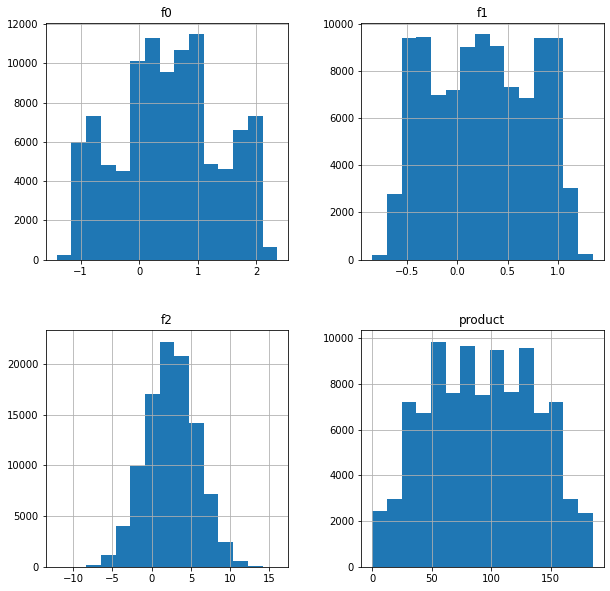

In [4]:
dataset_info(geo_data_0)

In [5]:
#Замечаем, что по столбцу id имеется дубликаты, проверим
geo_data_0.loc[geo_data_0['id'].duplicated(keep=False)].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


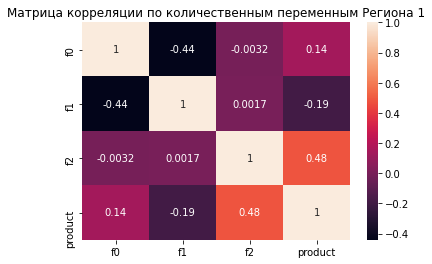

In [6]:
drop_data_for_corr = ['id']
sns.heatmap(geo_data_0.drop(drop_data_for_corr,axis=1).corr(),annot=True)
plt.title('Матрица корреляции по количественным переменным Региона 1');

**Промежуточный вывод**  
В первом регионе:
- нулевые значения отсутствуют.
- имеются 10 дубликатов уникального id. Возможно ошибка при выгрузке данных, так как признаки данных различные между собой.   
Цель нашего проекта выбрать регион, поэтому дубликаты оставим.

- Среднее кол-во баррелей в регионе 1 - 92.5 тыс.
- Распределение тыс. баррелей нормальное с 4 модами (50, 75, 100, 125)
- все три признака держаься в диапозоне 10 е.и.
- Зависимость между данными и признаками f0 и f1 слабая, однако замечается положительная корреляция между f2 и кол-вом баррелей в скважине 

### Информация о втором регионе

'Первые пять строк датасета'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Описание датасета'

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,LHZR0,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


'Гистограммы'

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

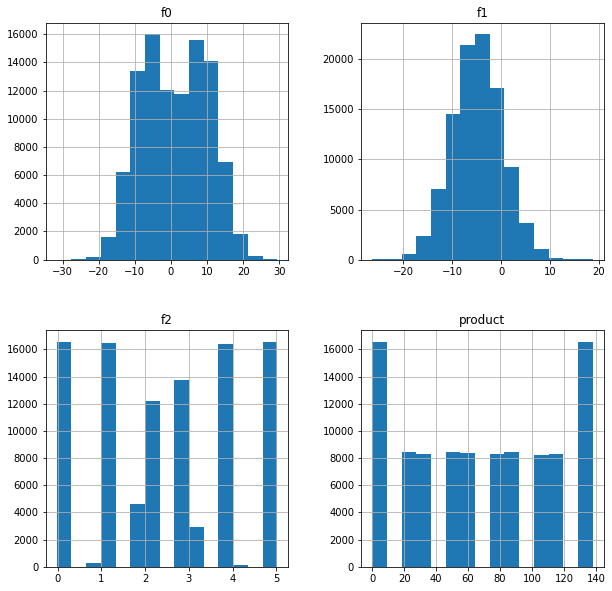

In [7]:
dataset_info(geo_data_1)

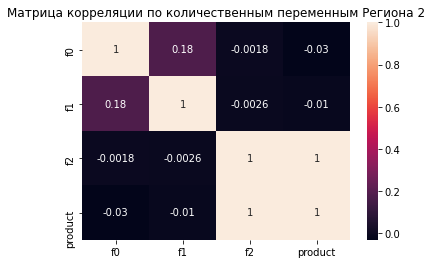

In [8]:
drop_data_for_corr = ['id']
sns.heatmap(geo_data_1.drop(drop_data_for_corr,axis=1).corr(),annot=True)
plt.title('Матрица корреляции по количественным переменным Региона 2');

**Промежуточный вывод**  
Во втором регионе:
- нулевые значения отсутствуют.
- имеются 4 дубликата уникального id. Возможно ошибка при выгрузке данных, так как признаки данных различные между собой.   
Цель нашего проекта выбрать регион, поэтому дубликаты оставим.

- Среднее кол-во баррелей в регионе 1 - 68.825 тыс.
- Замечаем 2 моды (0 и 130), распределено дискретно.
- Полная линейная зависимость между признаком f2 и product. В основном это является проблемой, так как модель будет игнорировать значения других признаков при прогнозе. Но оставим данный признак, так как его исключение повлияет на качество модели.

### Информация о третьем регионе

'Первые пять строк датасета'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Описание датасета'

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


'Гистограммы'

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

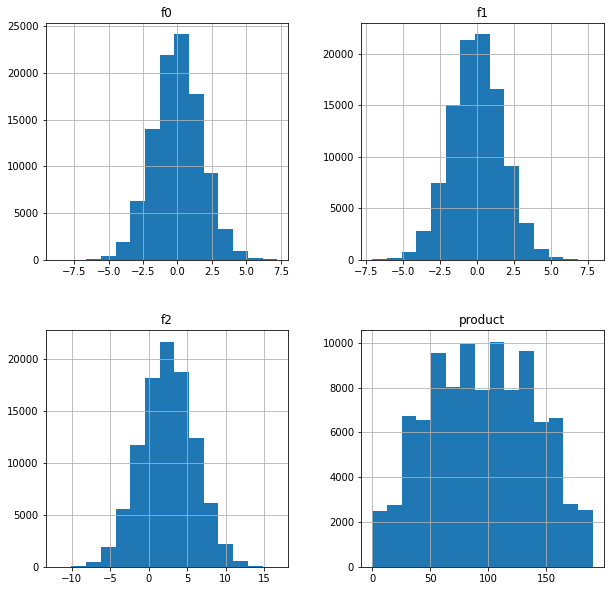

In [9]:
dataset_info(geo_data_2)

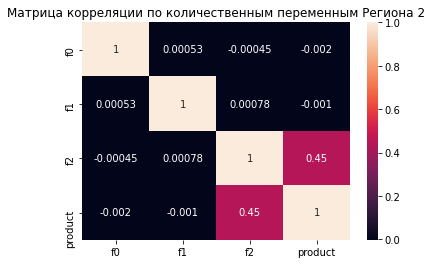

In [10]:
drop_data_for_corr = ['id']
sns.heatmap(geo_data_2.drop(drop_data_for_corr,axis=1).corr(),annot=True)
plt.title('Матрица корреляции по количественным переменным Региона 2');

**Промежуточный вывод**  
В третьем регионе:
- нулевые значения отсутствуют.
- имеются 4 дубликата уникального id. Возможно ошибка при выгрузке данных, так как признаки данных различные между собой.   
Цель нашего проекта выбрать регион, поэтому дубликаты оставим.

- Среднее кол-во баррелей в регионе 2 - 95.0 тыс.
- Распределение тыс. баррелей нормальное с 4 модами (50, 75, 100, 125)
- все три признака держаься в диапозоне 10 е.и.
- Зависимость между данными и признаками f0 и f1 слабая, однако замечается положительная корреляция между f2 и кол-вом баррелей в скважине 

### Общий вывод по первому разделу

По первичной информации о каждом регионе имеем:
- сильная зависимость во втором регионе признака f2 от product, такая зависмость можеть дать нам высокие баллы предсказаний для нашей модели.
- Столбец product является целевым признаком
- Высокое среднее кол-во в регионе 1 (95.5 тыс. баррелей) и в регионе 2 (95 тыс. баррелей)
- Имеются дубликаты, но на основую цель проекта не повлияют. Столбец id можно исключить со всех датафреймов, так как не несет в себе дополнительной информации.

## Обучение и проверка модели

Исключим столбец id из каждого датасета

In [11]:
geo_data_0 = geo_data_0.drop('id',axis=1)
geo_data_1 = geo_data_1.drop('id',axis=1)
geo_data_2 = geo_data_2.drop('id',axis=1)

### Разобьём данные на обучающую и валидационную выборки в соотношении 75:25

In [12]:
target_0 = geo_data_0['product']
features_0 = geo_data_0.drop(['product'], axis=1)

target_1 = geo_data_1['product']
features_1 = geo_data_1.drop(['product'], axis=1)

target_2 = geo_data_2['product']
features_2 = geo_data_2.drop(['product'], axis=1)

#### Деление на тренировочну и валидационную выборки по 1 региону

In [13]:
features_train_0, features_valid_0,\
target_train_0, target_valid_0 = \
train_test_split(features_0, 
                 target_0, 
                 test_size=0.25, 
                 random_state=12345)

print(f'Размер обучающей выборки{features_train_0.shape}, целевого тренировочного признака{target_train_0.shape}')
print(f'Размер валидационной выборки{features_valid_0.shape}, целевого валидационного признака{target_valid_0.shape}')

Размер обучающей выборки(75000, 3), целевого тренировочного признака(75000,)
Размер валидационной выборки(25000, 3), целевого валидационного признака(25000,)


#### Деление на тренировочну и валидационную выборки по 2 региону

In [14]:
features_train_1, features_valid_1,\
target_train_1, target_valid_1 = \
train_test_split(features_1, 
                 target_1, 
                 test_size=0.25, 
                 random_state=12345)

print(f'Размер обучающей выборки{features_train_1.shape}, целевого тренировочного признака{target_train_1.shape}')
print(f'Размер валидационной выборки{features_valid_1.shape}, целевого валидационного признака{target_valid_1.shape}')

Размер обучающей выборки(75000, 3), целевого тренировочного признака(75000,)
Размер валидационной выборки(25000, 3), целевого валидационного признака(25000,)


#### Деление на тренировочну и валидационную выборки по 3 региону

In [15]:
features_train_2, features_valid_2,\
target_train_2, target_valid_2 = \
train_test_split(features_2, 
                 target_2, 
                 test_size=0.25, 
                 random_state=12345)

print(f'Размер обучающей выборки{features_train_2.shape}, целевого тренировочного признака{target_train_2.shape}')
print(f'Размер валидационной выборки{features_valid_2.shape}, целевого валидационного признака{target_valid_2.shape}')

Размер обучающей выборки(75000, 3), целевого тренировочного признака(75000,)
Размер валидационной выборки(25000, 3), целевого валидационного признака(25000,)


### Обучим модель и сделаем предсказания на валидационной выборке, а так же оценим качество модели техникой RMSEи коэффициентом детерминации R2

#### Модель линейная регрессия первого региона

In [16]:
model_0 = LinearRegression()
model_0.fit(features_train_0,target_train_0)
predict_0 = model_0.predict(features_valid_0)
mse_0 = mean_squared_error(target_valid_0, predict_0)
rmse_0 = mse_0**0.5
mae_0 = mean_absolute_error(target_valid_0, predict_0)
print('Среднее абсолютное отклонение MAE: %.2f'% mae_0)
print('Среднеквадратичная ошибка MSE: %.2f'% mse_0)
print('RMSE: %.2f'% rmse_0)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_0, predict_0))

Среднее абсолютное отклонение MAE: 30.92
Среднеквадратичная ошибка MSE: 1412.21
RMSE: 37.58
Коэффициент детерминации: 0.28


#### Модель линейная регрессия второго региона

In [17]:
model_1 = LinearRegression()
model_1.fit(features_train_1,target_train_1)
predict_1 = model_1.predict(features_valid_1)
mse_1 = mean_squared_error(target_valid_1, predict_1)
rmse_1 = mse_1**0.5
mae_1 = mean_absolute_error(target_valid_1, predict_1)
print('Среднее абсолютное отклонение MAE: %.2f'% mae_1)
print('Среднеквадратичная ошибка MSE: %.2f'% mse_1)
print('RMSE: %.2f'% rmse_1)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_1, predict_1))

Среднее абсолютное отклонение MAE: 0.72
Среднеквадратичная ошибка MSE: 0.80
RMSE: 0.89
Коэффициент детерминации: 1.00


#### Модель линейная регрессия третьего региона

In [18]:
model_2 = LinearRegression()
model_2.fit(features_train_2,target_train_2)
predict_2 = model_2.predict(features_valid_2)
mse_2 = mean_squared_error(target_valid_2, predict_2)
rmse_2 = mse_2**0.5
mae_2 = mean_absolute_error(target_valid_2, predict_2)
print('Среднее абсолютное отклонение MAE: %.2f'% mae_2)
print('Среднеквадратичная ошибка MSE: %.2f'% mse_2)
print('RMSE: %.2f'% rmse_2)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_2, predict_2))

Среднее абсолютное отклонение MAE: 32.79
Среднеквадратичная ошибка MSE: 1602.38
RMSE: 40.03
Коэффициент детерминации: 0.21


### Сохраним предсказания и правильные ответы на валидационной выборке

In [19]:
print(f'1 регион:\n- предсказания модели хранятся в переменной: "predict_0"\n- правильные ответы: "target_valid_0"')
print()
print('2 регион:\n- предсказания модели хранятся в переменной: "predict_1"\n- правильные ответы: "target_valid_1"')
print()
print('3 регион:\n- предсказания модели хранятся в переменной: "predict_2"\n- правильные ответы: "target_valid_2"')

1 регион:
- предсказания модели хранятся в переменной: "predict_0"
- правильные ответы: "target_valid_0"

2 регион:
- предсказания модели хранятся в переменной: "predict_1"
- правильные ответы: "target_valid_1"

3 регион:
- предсказания модели хранятся в переменной: "predict_2"
- правильные ответы: "target_valid_2"


### Напечатаем на экране средний запас предсказанного сырья и RMSE модели

In [20]:
total_m_pred = pd.DataFrame(index=['mean_pred_resources','RMSE_model'])
total_m_pred['1_region'] = [predict_0.mean(), rmse_0]
total_m_pred['2_region'] = [predict_1.mean(), rmse_1]
total_m_pred['3_region'] = [predict_2.mean(), rmse_2]
total_m_pred

,1_region,2_region,3_region
mean_pred_resources,92.592568,68.728547,94.965046
RMSE_model,37.579422,0.893099,40.029709


### Общий вывод по второму разделу

Замечаем, что лучше всего себя показала модель по второму региону:
- Среднее абсолютное отклонение MAE: 0.72
- Среднеквадратичная ошибка MSE: 0.80
- RMSE: 0.89
- Коэффициент детерминации: 1.00
Причина в линейной зависимости признака f2 от product.  

Среднее предсказанное значение сырья и RSME моделей следующие:  

| Значения | Первый регион | Второй регион | Третий регион |
| --- | --- | --- | --- |
| Средний запас предсказанного сырья, тыс. баррелей | 92.592568 | 68.728547 | 94.965046 |
| RSME модели | 37.579422 | 0.893099 | 40.029709 |  

Больше всего среднее значение тыс. баррелей в третьем регионе

## Подготовка к расчёту прибыли

### Ключевые значения для расчетов

При разведке региона исследуюем **500** точек, из которых с помощью машинного обучения выберем **200** лучших для разработки.
Бюджет на разработку скважин в регионе — **10 млрд рублей**.  

При нынешних ценах один баррель сырья приносит **450 рублей дохода**. Доход с каждой единицы продукта составляет **450 тыс.
рублей**, поскольку объём указан в тысячах баррелей.  

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше **2.5%**. Среди них выберем регион с наибольшей средней прибылью.

In [21]:
budget = 10000000 
#бюджет на разработку скважин в регионе, тыс.руб
income_one_prod = 450 
#доход с каждой единицы продукта, тыс.руб
target_probability_losses = 2.5/100 
# вероятность убытков
product_mean_0 = geo_data_0['product'].mean()
product_mean_1 = geo_data_1['product'].mean()
product_mean_2 = geo_data_2['product'].mean()

In [22]:
print('Cредний запас сырья в 1 регионе: %.2f тыс.баррелей'%product_mean_0)
print('Cредний запас сырья в 2 регионе: %.2f тыс.баррелей'%product_mean_1)
print('Cредний запас сырья в 3 регионе: %.2f тыс.баррелей'%product_mean_2)

Cредний запас сырья в 1 регионе: 92.50 тыс.баррелей
Cредний запас сырья в 2 регионе: 68.83 тыс.баррелей
Cредний запас сырья в 3 регионе: 95.00 тыс.баррелей


In [23]:
budg_per_1_point=(budget/200)# тыс.руб
print('Бюджет на разработку одной скважины:', budg_per_1_point/1000,'млн.руб')

Бюджет на разработку одной скважины: 50.0 млн.руб


In [24]:
v_prod=budg_per_1_point/income_one_prod
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%v_prod,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


### Сравним безубыточный объём сырья со средним запасом в каждом регионе

In [25]:
# для первого региона посчитаем прибыль
geo_data_0['profit']=(geo_data_0['product']*(income_one_prod)).round(2) # profit, тыс.руб
geo_data_0.head()

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.221170,105.280062,47376.03
1,1.334711,-0.340164,4.365080,73.037750,32866.99
2,1.022732,0.151990,1.419926,85.265647,38369.54
3,-0.032172,0.139033,2.978566,168.620776,75879.35
4,1.988431,0.155413,4.751769,154.036647,69316.49


In [26]:
# для второго региона посчитаем прибыль
geo_data_1['profit']=(geo_data_1['product']*(income_one_prod)).round(2) # profit, тыс.руб
geo_data_1.head()

,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,14.272088,-3.475083,0.999183,26.953261,12128.97
2,6.263187,-5.948386,5.001160,134.766305,60644.84
3,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,12.702195,-8.147433,5.004363,134.766305,60644.84


In [27]:
# для третьего региона посчитаем прибыль
geo_data_2['profit']=(geo_data_2['product']*(income_one_prod)).round(2) # profit, тыс.руб
geo_data_2.head()

,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,0.262778,0.269839,-2.530187,56.069697,25231.36
2,0.194587,0.289035,-5.586433,62.871910,28292.36
3,2.236060,-0.553760,0.930038,114.572842,51557.78
4,-0.515993,1.716266,5.899011,149.600746,67320.34


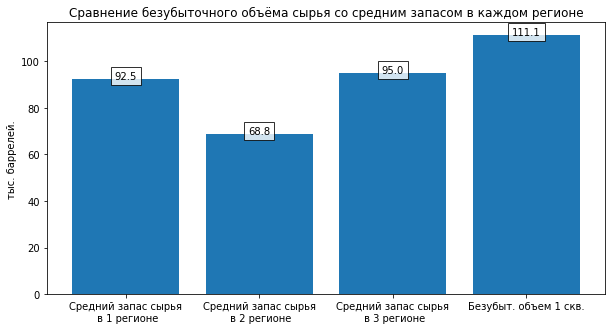

In [28]:
#внесем значения в отдельну переменную и построим столбчатую диаграмму
#функция для добавления надписи в стобчатую диаграмму
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],round(y[i],1),ha = 'center',
                Bbox = dict(facecolor = 'white', alpha =.8))

        
index_mean_vs_cost = ["Cредний запас сырья\n в 1 регионе","Cредний запас сырья\n в 2 регионе",
                      "Cредний запас сырья\n в 3 регионе","Безубыт. объем 1 скв."]
values_mean_vs_cost = [product_mean_0,
                        product_mean_1,
                        product_mean_2, 
                       v_prod]
plt.figure(figsize = (10,5))
plt.bar(index_mean_vs_cost,height=values_mean_vs_cost)
addlabels(index_mean_vs_cost,values_mean_vs_cost)
plt.title('Сравнение безубыточного объёма сырья со средним запасом в каждом регионе')
plt.ylabel('тыс. баррелей.');

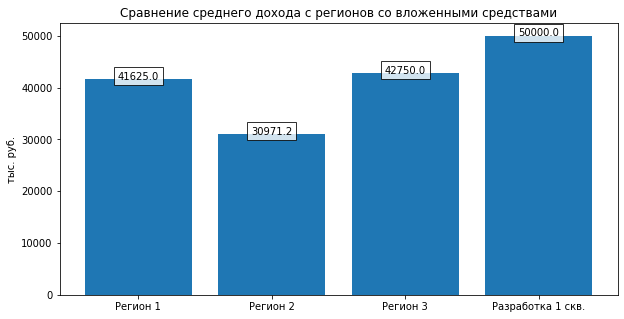

In [29]:
#внесем значения в отдельну переменную и построим столбчатую диаграмму
index_mean_vs_cost = ["Регион 1","Регион 2",
                      "Регион 3","Разработка 1 скв."]
values_mean_vs_cost = [geo_data_0['profit'].mean(),geo_data_1['profit'].mean(),
                       geo_data_2['profit'].mean(), budg_per_1_point]
plt.figure(figsize = (10,5))
plt.bar(index_mean_vs_cost,height=values_mean_vs_cost)
addlabels(index_mean_vs_cost,values_mean_vs_cost)
plt.title('Сравнение среднего дохода с регионов со вложенными средствами')
plt.ylabel('тыс. руб.');

Ни один из средних доходов с одной скважины не окупает скважину.

**Промежуточный вывод**:  

Записали следующие константы:
- budget -общий бюджет
- income_one_prod - доход с каждой единицы продукта
- target_probability_losses - наименьшая вероятность убытков
- budg_per_1_point - бюджет на разработку одной скважины
- v_prod - Объём каждой скважины для безубыточной разработки

Замечаем, что объем каждой скважины должен быть не менее 111.11 тыс. баррелей. Ни один из средних запасов региона не попадает под безубысточный запас, значит придется искать скважины с большим запасом тыс. баррелей.

**Главное - выбрать скважины с безубыточным объемом сырья.**
При выборе скважин **опираемся на предсказания, поэтому точность прогноза имеет большое значение и без модели нам не обойтись.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Создадим функцию для расчета прибыли по выбранным скважинам и предсказаниям модели

In [30]:
#на вход функция принимает предсказания модели по кол-ву баррелей,
#целевой признак для индексации и кол-во для отбора лучших скважин
def profit_for_best_keyhole(predict,target,count):
    
    #создаем отсортированный объект Series по нисходящей
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    
    #отбираем кол-во лучших скважин и суммируем баррели
    global selected_max
    selected_max = probs_sorted[:count].sum()
    
    #расчтаем прибыль
    profit_pred=(selected_max*income_one_prod)-budget
    
    print('суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

Расчитаем для первого региона

In [31]:
profit_for_best_keyhole(predict_0,target_valid_0,200)
#Присвоим глобальную переменную для дальнейших расчетов
sum_material_0 = selected_max

суммарный запас сырья в 200 лучших скважинах составит: 31102.33 тыс.баррелей
прибыль для полученного объёма сырья составит 3996.05 млн.рублей


Расчитаем для второго региона

In [32]:
profit_for_best_keyhole(predict_1,target_valid_1,200)
sum_material_1 = selected_max

суммарный запас сырья в 200 лучших скважинах составит: 27746.03 тыс.баррелей
прибыль для полученного объёма сырья составит 2485.71 млн.рублей


Расчитаем для третьего региона

In [33]:
profit_for_best_keyhole(predict_2,target_valid_2,200)
sum_material_2 = selected_max

суммарный запас сырья в 200 лучших скважинах составит: 29603.90 тыс.баррелей
прибыль для полученного объёма сырья составит 3321.75 млн.рублей


**Промежуточный вывод:**  
- Самый прибыльный регион 1 с прибылью 3996.05 млн.рублей
- На втором месте регион 3 - 3321.75 млн.рублей
- На последнем регион 2 - 2485.71 млн.рублей  

Расчеты выполнены по лучшим скважинам, для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка проведём расчёт вероятности.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [34]:
def profit_for_predict_keyhole(predict,target,count):
    #создадим аналог функции profit_for_best_keyhole возвращающий прибыль
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * income_one_prod
    return revenue - budget

In [35]:
def bootstap_for_predict(target,predict):
    #На вход функция получает целевой принзак и предсказания модели        
    #Создаем константы внутри функции
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    #применяем технику бустреп с 1000 выборок
    for i in range(1000):   
    #Выбираем 500 точек
        target_subsample = target.sample(n=500,replace=True, random_state=state)
    
    #добавляем значения исследуемых точек
        probs_subsample = predict_e[target_subsample.index]
    
    #добавляем в список 200 лучших скважин из сформированной выборки
        values.append(profit_for_predict_keyhole(probs_subsample,target_subsample, 200))  
    
    #считаем кол-во скважин с убытком
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    global mean
    mean = values.mean()
    global loss
    loss = count/1000
    
    #считаем доверительный интервал при помощи scipy
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    #построим гистограмму распределения прибыли
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    #считаем квантили
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'\
          .format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб"\
          .format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(loss))

**Применим функцию для первого регина**

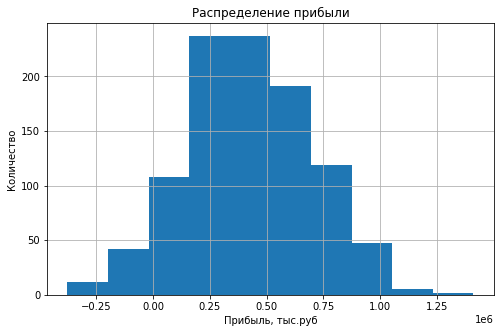

Средняя прибыль: 425.94 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102.09 млн.руб до: 947.98 млн.руб
95%-ый доверительный интервал: от 408.73 млн.руб до 443.14 млн.руб
Процент вероятности убытка в данном регионе составит 6.0%


In [36]:
bootstap_for_predict(target_valid_0,predict_0)
#Присвоим глобальное значение переменной региону
mean_predict_product_0 = mean
property_loss_0 = loss

**Применим функцию для второго регина**

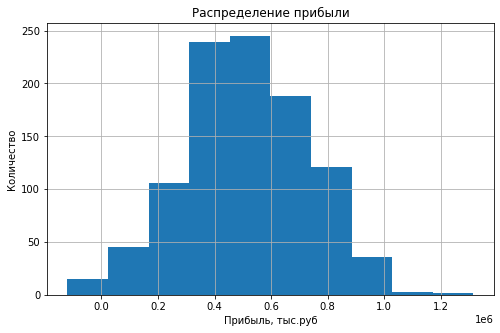

Средняя прибыль: 515.22 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 68.87 млн.руб до: 931.55 млн.руб
95%-ый доверительный интервал: от 501.62 млн.руб до 528.82 млн.руб
Процент вероятности убытка в данном регионе составит 1.0%


In [37]:
bootstap_for_predict(target_valid_1,predict_1)
mean_predict_product_1 = mean
property_loss_1 = loss

**Применим функцию для третьего регина**

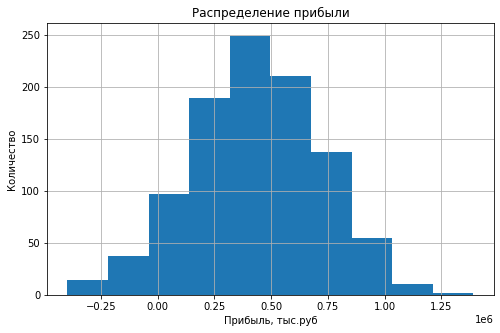

Средняя прибыль: 435.01 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -128.88 млн.руб до: 969.71 млн.руб
95%-ый доверительный интервал: от 417.45 млн.руб до 452.56 млн.руб
Процент вероятности убытка в данном регионе составит 6.4%


In [38]:
bootstap_for_predict(target_valid_2,predict_2)
mean_predict_product_2 = mean
property_loss_2 = loss

**Проанализируем итоговые параметры регионов**

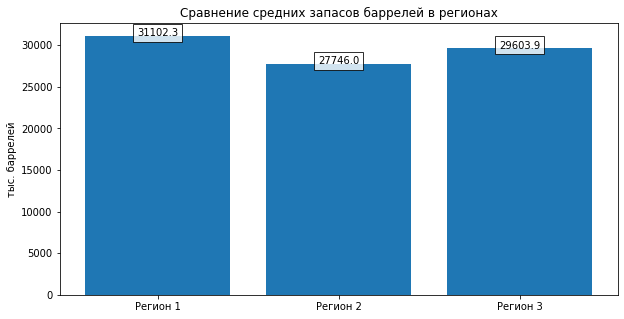

In [39]:
index_mean_vs_cost = ["Регион 1","Регион 2",
                      "Регион 3"]
values_mean_vs_cost = [sum_material_0, sum_material_1, sum_material_2]
plt.figure(figsize = (10,5))
plt.bar(index_mean_vs_cost,height=values_mean_vs_cost)
addlabels(index_mean_vs_cost,values_mean_vs_cost)
plt.title('Сравнение средних запасов баррелей в регионах')
plt.ylabel('тыс. баррелей');

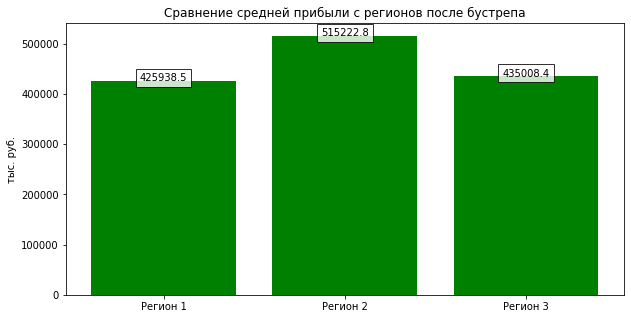

In [40]:
index_mean_vs_cost = ["Регион 1","Регион 2",
                      "Регион 3"]
values_mean_vs_cost = [mean_predict_product_0, mean_predict_product_1, mean_predict_product_2]
plt.figure(figsize = (10,5))
plt.bar(index_mean_vs_cost,height=values_mean_vs_cost,color = 'g')
addlabels(index_mean_vs_cost,values_mean_vs_cost)
plt.title('Сравнение средней прибыли с регионов после бустрепа')
plt.ylabel('тыс. руб.');

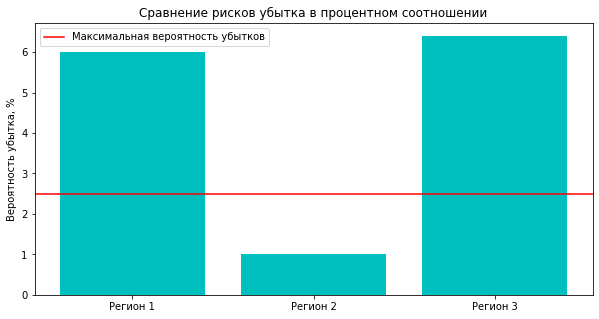

In [41]:
index_mean_vs_cost = ["Регион 1","Регион 2",
                      "Регион 3"]
values_mean_vs_cost = [property_loss_0*100, property_loss_1*100, property_loss_2*100]
plt.figure(figsize = (10,5))
plt.axhline(y=2.5, color='r', linestyle='-', label='Максимальная вероятность убытков')
plt.legend(loc = 'upper left')
plt.bar(index_mean_vs_cost,height=values_mean_vs_cost,color='c')
plt.title('Сравнение рисков убытка в процентном соотношении')
plt.ylabel('Вероятность убытка, %');

### Вывод

Мы применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. по итогу подчернем следующие пункты:

1. По первому региону  
    - Средняя прибыль: **425.94 млн.руб**
    - С вероятностью 95% прибыль в данном регионе будет составлять от: **-102.09 млн.руб до: 947.98 млн.руб**
    - 95%-ый доверительный интервал: **от 408.73 млн.руб до 443.14 млн.руб**
    - Процент вероятности убытка в данном регионе составит **6.0%**
2. По второму региону  
    - Средняя прибыль: **515.22 млн.руб**
    - С вероятностью 95% прибыль в данном регионе будет составлять от: **68.87 млн.руб до: 931.55 млн.руб**
    - 95%-ый доверительный интервал: от **501.62 млн.руб до 528.82 млн.руб**
    - Процент вероятности убытка в данном регионе составит **1.0%**
3. По третьему региону  
    - Средняя прибыль: **435.01 млн.руб**
    - С вероятностью 95% прибыль в данном регионе будет составлять от: **-128.88 млн.руб до: 969.71 млн.руб**
    - 95%-ый доверительный интервал: от **417.45 млн.руб до 452.56 млн.руб**
    - Процент вероятности убытка в данном регионе составит **6.4%**

Несмотря на меньший запас баррелей по второму региону, с учетом рисков убытков, второй регион является более прибыльным по отношению к другим регионам - мин. прибыль 68.87 млн.   
У остальных имеется большая вероятность убытков в 95% доверительном интервале 1 регион - 102.09 млн, 3 регион -128.88 млн руб.



##  Общий вывод

Целью нашего проекта было посчитать прибыль и риски для каждого региона и выбрать наиболее рентабельный. Прошли следующий путь:
1. Изучили данные о регионах;
    - Во время изучения пустых признаках на объектах не обнаружены
    - Выявлены дубликаты по уникальному индетификатору(1рег.-10 дубл, 2рег.-4дубл., 3рег.-4дубл.). Так как признаки этих скважин оказались разными, мы не исключали из датасета. Возможно техническая причина в выгрузке данных.
    - Замечена полная линейная зависимость признака f2 от product в регионе 2. линейная модель в данном случае может полностью игнорировать признаки f0 и f1. Однако показатели модели будут наилучшими.
 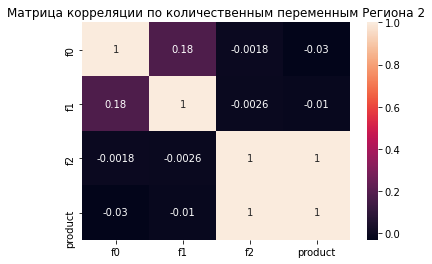   

2. Построили модель линейной регрессии для определения кол-ва бареллей в регионах. Является обучение с учителем. Изучили качество модели. Получили следующие итоги:
    - **1 регион**
        - RMSE: 37.58
        - Коэффициент детерминации: 0.28
    - **2 регион**
        - RMSE: 0.89
        - Коэффициент детерминации: 1.00
    - **3 регион**
        - RMSE: 40.03
        - Коэффициент детерминации: 0.21
    - Лучше всего показа себя модель 2 региона.
    - Сохранили результаты предсказания и средний запас каждого для дальнейших рассчетов
| Значения | Первый регион | Второй регион | Третий регион |
| --- | --- | --- | --- |
| Средний запас предсказанного сырья, тыс. баррелей | 92.592568 | 68.728547 | 94.965046 |

3. Расчитали прибыль и риски убытка. Выбрали самый рентабельный регион.
    - Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей (50 млн руб.) с учетом выбора **200** лучших для разработки
    - Ни один из регионов по среднему запасу не окупает затраты.
    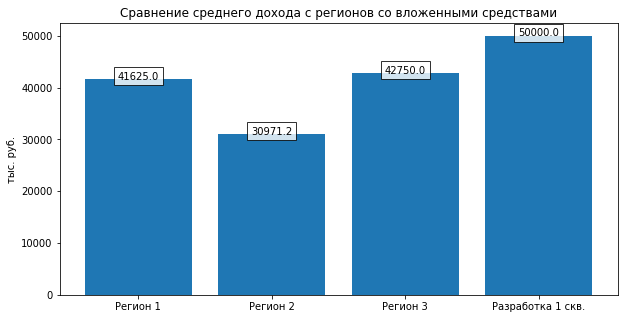
    - Выбрали 200 лучших скважин по региону.
    - **1 регион:**
        - суммарный запас сырья в 200 лучших скважинах составит: **31102.33 тыс.баррелей**
        - прибыль для полученного объёма сырья составит **3996.05 млн.рублей**
    - **2 регион:**
        - суммарный запас сырья в 200 лучших скважинах составит: **27746.03 тыс.баррелей**
        - прибыль для полученного объёма сырья составит **2485.71 млн.рублей**
    - **3 регион:**
        - суммарный запас сырья в 200 лучших скважинах составит: **29603.90 тыс.баррелей**
        - прибыль для полученного объёма сырья составит **3321.75 млн.рублей**
    - Провели расчеты прибыли с учетом рисков:
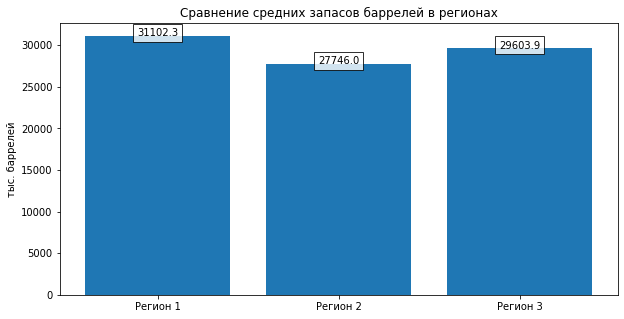
    - максимальное кол-во запасов баррелей в регионе 1
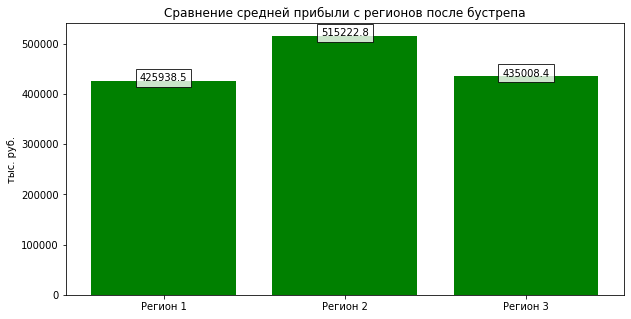
    - однако, с учетом рисков, больше всего прибыль принесет регион 2.
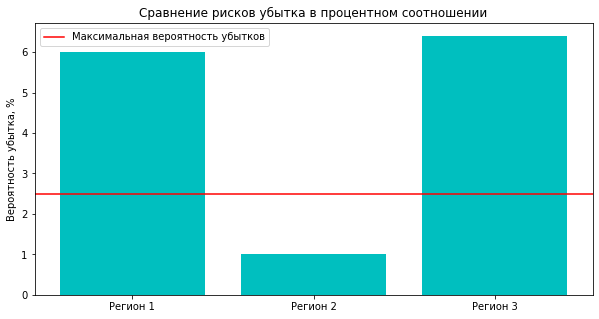
    - имеющий минимальную вероятность убытка в 1%

Предлагаю второй регион для разработки месторождения с учетом вышеизложенного.
    
**Рекомендации**:
   - более подробно изучить признак f2, имеющий положительную корреляцию от кол-ва баррелей в скважине.
   - Присвоить новые уникальные индификаторы по скважинам для исключения дубликатов.